In [21]:
#Part1: preprocessing
#1
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup

#3
data_import = pd.read_csv("Tweets.csv")
data = data_import.copy() #I'm working with a copy of the dataset (to avoid modifying the original dataset)

#4
data = data[data['airline_sentiment_confidence'] > 0.65]

#5
data['sentiment'] = data['airline_sentiment'].map({'neutral': 0, 'positive': 0, 'negative': 1})

#6
#In the column 'text', we can find some tags like (amp;) that belong to html error avoidance. They need to be removed! How? BeautifulSoup.
def clean(text):
    return BeautifulSoup(text, "lxml").text 
#parser = analyseur: ywadha7 html/xml doc ki yabda fyh text+tags so that Python makes sense of it.
#lxml is a parser that supports both html and xml docs => flexibility 
data['text_clean'] = data['text'].apply(clean)

#7
data = data.loc[:,['text_clean', 'sentiment']]
data

C:\Users\Dhoha\AppData\Local\Temp\ipykernel_14964\2960264809.py:21: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  return BeautifulSoup(text, "lxml").text


,text_clean,sentiment
0,@VirginAmerica What @dhepburn said.,0
2,@VirginAmerica I didn't today... Must mean I n...,0
3,@VirginAmerica it's really aggressive to blast...,1
4,@VirginAmerica and it's a really big bad thing...,1
5,@VirginAmerica seriously would pay $30 a fligh...,1
...,...,...
14634,@AmericanAir right on cue with the delays👌,1
14636,@AmericanAir leaving over 20 minutes Late Flig...,1
14637,@AmericanAir Please bring American Airlines to...,0
14638,"@AmericanAir you have my money, you change my ...",1


In [22]:
#Part2: model building
from sklearn.model_selection import train_test_split

#1
train, test = train_test_split(
    data, 
    test_size=0.2, 
    random_state=1)

#2
X_train = data['text_clean'].values
X_test = data['text_clean'].values
y_train = data['sentiment']
y_test = data['sentiment']

#3
import nltk #nltk is a library specialized in working with human language data
from nltk.tokenize import TweetTokenizer #this module helps splitting the text into words
from nltk.stem import PorterStemmer #PorterStemmer to reduce words to their root form (it helps with the performance of the algorithme)


#tokenization function
def tkn(txt):
    tokenizer = TweetTokenizer()
    tokens = tokenizer.tokenize(txt)
    return tokens 
#stemming function
def stm(word):
    stemmer = PorterStemmer()
    return [stemmer.stem(w) for w in tkn(word)]

#4
#stopwords are words with little value to the accuracy of the algorithm
from nltk.corpus import stopwords
nltk.download('stopwords')
ESW = list(stopwords.words('english'))

#5
from sklearn.feature_extraction.text import CountVectorizer #this library helps transforming our data into a numerical representation!
#numerical conversion is crucial for ML algorithm

vzr = CountVectorizer(
    analyzer = 'word',#word level tokenization
    tokenizer = tkn,
    lowercase = True,
    ngram_range = (1, 1),
    stop_words = ESW
)

#6
from sklearn.model_selection import StratifiedKFold

SKF = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
#Using StratifiedKFold assure maintaining the same distribution of classes in each Fold (for more relevant training)

#7
np.random.seed(1) #ensures getting the same result with each code execution

#8
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC

ppln = make_pipeline(
    vzr,
    SVC(
        probability=True,
        kernel="linear",
        class_weight="balanced"
    )
)

ppln.fit(X_train, y_train)
ppln.score(X_test, y_test)



[nltk_data] Downloading package stopwords to C:\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
C:\Users\Dhoha\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


0.9706248626474251

In [29]:
#9
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

def report_results(model, a, b):
    
    prdc = model.predict(a)
    acc = accuracy_score(b, prdc)
    prec = precision_score(b, prdc)
    recall = recall_score(b, prdc)
    fscore = f1_score(b, prdc)
    
    prdc_proba = model.predict_proba(a)[:,1]
    auc = roc_auc_score(b, prdc_proba)#a metric of how well the model distinguishes between positive and negative instances
    
    res = {'AUC': auc, 'Accuracy': acc, 'F1_score': fscore, 'Precision': prec, 'Recall': recall}
    return res

report_results(ppln, X_test, y_test)



{'AUC': 0.9926664194039639,
 'Accuracy': 0.9706248626474251,
 'F1_score': 0.9769075727037143,
 'Precision': 0.9888085800885987,
 'Recall': 0.965289632411517}

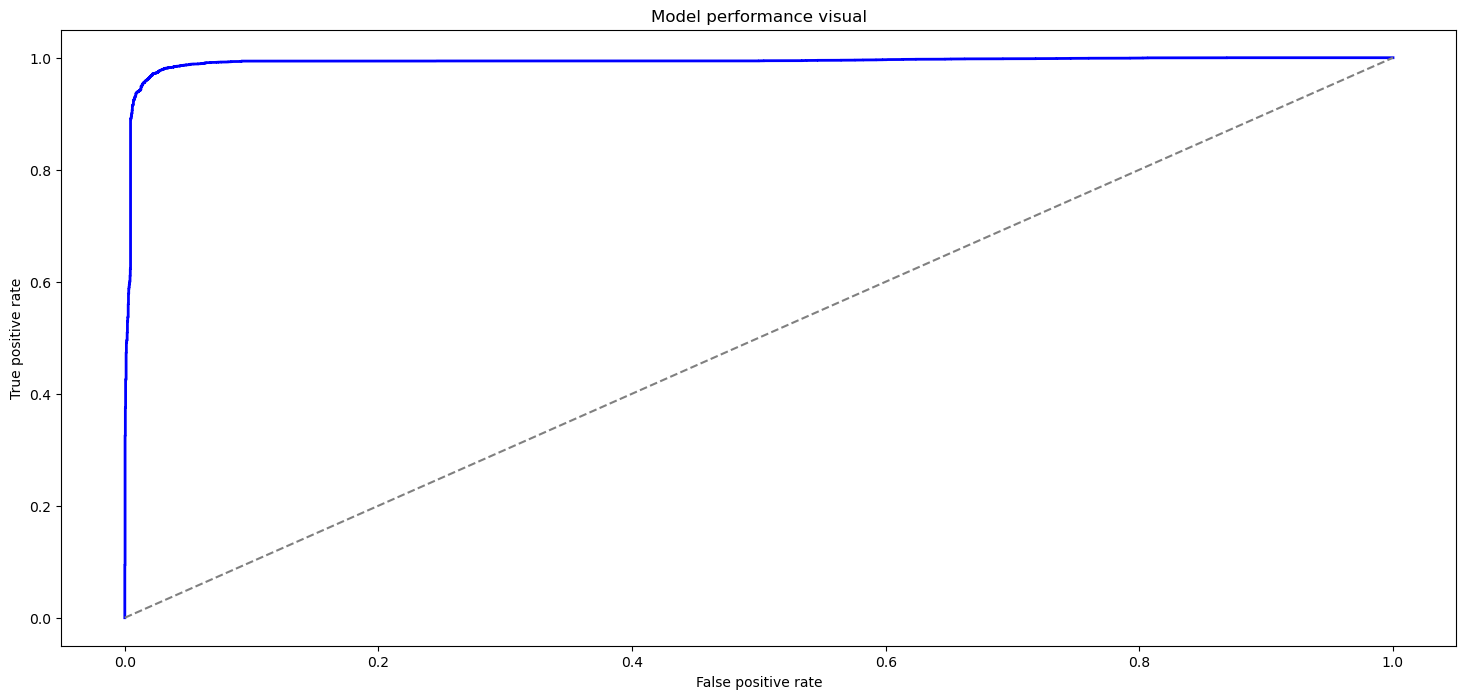

In [27]:
#10
from sklearn.metrics import roc_curve 

def get_roc_curve(model, a, b):
    prdc_proba = model.predict_proba(a)[:,1]
    fpr, tpr, _ = roc_curve(b, prdc_proba)
    return fpr, tpr

#11
import matplotlib.pyplot as plt

plt.figure(figsize=(18,8))
fpr, tpr = get_roc_curve(ppln, X_test, y_test)
plt.plot(fpr, tpr, color='blue', lw=2)#a visual representation of the model's performance.
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')#a line that represents the minimum acceptable performance by a classifier (un repère) 

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Model performance visual')

#12
plt.show()

In [38]:
ppln.predict(["@united stupidly awsome experience!"])

array([0], dtype=int64)